### Summarising Calibration Results

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, gaussian_kde
from matplotlib.lines import Line2D
import pyabc
from network_input_builder import *
path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"


In [2]:

sns.set_style("whitegrid")

which_params = "full_omn"

if which_params == "onet":
    nw_label = "ONET"
elif which_params == "full_omn":
    nw_label = "Occupational Mobility Network"

# list of model identifiers (your db_path values)
models = [
    "nonbehav",
    "otj_nonbehav",
    "otj_disc_no_rw",
    "otj_cyclical_e_disc_no_rw",
    "otj_disc",
    "otj_cyclical_e_disc"

]

# human-readable mapping
name_map = {
    "nonbehav": "Non-behavioural",
    "otj_nonbehav": "Non-behavioural w. OTJ",
    "otj_cyclical_e_disc": "Behavioural w. Cyc. OTJ w. RW",
    "otj_disc": "Behavioural w.o. Cyc. OTJ w. RW",
    "otj_cyclical_e_disc_no_rw": "Behavioural w. Cyc. OTJ w.o RW",
    "otj_disc_no_rw": "Behavioural w.o. Cyc. OTJ w.o RW",
}



In [3]:
# replace this function with your actual loader that returns (df, w)
def load_model_distribution(db_path):
    """
    Return (df, w) for a model. Replace this with your code that
    reads history and calls history.get_distribution(t=history.max_t).
    df: pandas.DataFrame with columns 'd_u', 'gamma_u', optional 'theta'
    w: 1D numpy array of weights aligned with df.index
    """
    # --- PLACEHOLDER: replace with your actual loader ---
    history = pyabc.History("sqlite:///" + f"output/{which_params}/{name}.db")
    print(f"output/{which_params}/{name}.db")
    df, w = history.get_distribution(t=history.max_t)
    if len(df) == 0:
        print(f'{name} empty')

    return df, w

# safe kde wrapper: uses seaborn weights when available, else resamples
def plot_kde_on_ax(ax, x, y=None, weights=None, label=None, color=None, bw_adjust=1.0, fill=False, levels=6):
    """
    If y is None -> 1d kde; if y provided -> 2d kde contour.
    Tries to use sns.kdeplot(weights=...). If seaborn does not support weights for your version,
    falls back to weighted resampling.
    """
    use_seaborn_weights = True
    try:
        # try a direct call - will raise if weights unsupported
        if y is None:
            sns.kdeplot(x=x, ax=ax, weights=weights, label=label, color=color, bw_adjust=bw_adjust, fill=fill)
        else:
            sns.kdeplot(x=x, y=y, ax=ax, weights=weights, color=color, levels=levels, bw_adjust=bw_adjust, fill=fill)
        return
    except TypeError:
        use_seaborn_weights = False

    # fallback: weighted resample
    n_resample = min(4000, max(500, int(len(x) * 0.1)))  # sample up to 4000 points
    if weights is None:
        idx = np.random.choice(len(x), size=n_resample, replace=True)
    else:
        p = np.array(weights, dtype=float)
        p = p / p.sum()
        idx = np.random.choice(len(x), size=n_resample, replace=True, p=p)

    xs = np.asarray(x)[idx]
    if y is None:
        sns.kdeplot(x=xs, ax=ax, label=label, color=color, bw_adjust=bw_adjust, fill=fill)
    else:
        ys = np.asarray(y)[idx]
        sns.kdeplot(x=xs, y=ys, ax=ax, label=label, color=color, levels=levels, bw_adjust=bw_adjust, fill=fill)


# Collect all model samples
samples = {}
for name in models:
    try:
        df, w = load_model_distribution(name)
    except NotImplementedError:
        # ####### TEMP TEST DATA (remove when you plug in real loader) #######
        # Create a toy df to let the script run for demo purposes.
        rng = np.random.RandomState(abs(hash(name)) % 2**32)
        n = 2000
        # d_u and gamma_u vary by model label
        base = {"nonbehav": 0.2, "otj_nonbehav": 0.25, "otj_disc": 0.3,
                "otj_disc_no_rw": 0.28, "otj_cyclical_e_disc": 0.45, "otj_cyclical_e_disc_no_rw": 0.42}
        theta_present = name in ("otj_cyclical_e_disc", "otj_cyclical_e_disc_no_rw")
        df = pd.DataFrame({
            "d_u": rng.normal(loc=base[name], scale=0.03, size=n),
            "gamma_u": rng.normal(loc=base[name]*1.5, scale=0.05, size=n),
        })
        if theta_present:
            df["theta"] = rng.normal(loc=0.35, scale=0.06, size=n)
        w = np.ones(len(df)) / len(df)
        # ###################################################################
    samples[name] = {"df": df, "w": np.asarray(w)}

# palette & colors
palette = sns.color_palette("Paired", 12)

blues      = palette[0:2]
greens     = palette[2:4]
reds       = palette[4:6]
oranges    = palette[6:8]
purples    = palette[8:10]
yellows    = palette[10:12]

my_colors = blues + oranges + purples
colors = dict(zip(models, my_colors))

# compute global axis limits for nicer consistent plotting
def global_limits(col, pad_frac=0.05):
    vals = []
    for m in samples:
        ser = samples[m]["df"].get(col)
        if ser is None: continue
        vals.append(ser.values)
    if len(vals) == 0:
        return None
    arr = np.concatenate(vals)
    lo, hi = np.nanpercentile(arr, [0.5, 99.5])
    rng = hi - lo
    return (max(0, lo - pad_frac*rng), hi + pad_frac*rng)

du_lim = global_limits("d_u")
gu_lim = global_limits("gamma_u")
theta_lim = global_limits("theta")

limit_buffer = 0
du_min, du_max = global_limits("d_u")
gu_min, gu_max = global_limits("gamma_u")
theta_min, theta_max = global_limits("theta")

du_min -= limit_buffer
du_max += limit_buffer
gu_min -= limit_buffer
gu_max += limit_buffer
theta_min -= limit_buffer
theta_max += limit_buffer

out_dir = f'output/{which_params}/combined_plots'
os.makedirs(out_dir, exist_ok=True)



output/full_omn/nonbehav.db
output/full_omn/otj_nonbehav.db
output/full_omn/otj_disc_no_rw.db
output/full_omn/otj_cyclical_e_disc_no_rw.db
output/full_omn/otj_disc.db
output/full_omn/otj_cyclical_e_disc.db


nonbehav
otj_nonbehav
otj_disc_no_rw
otj_cyclical_e_disc_no_rw


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

otj_disc
otj_cyclical_e_disc


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

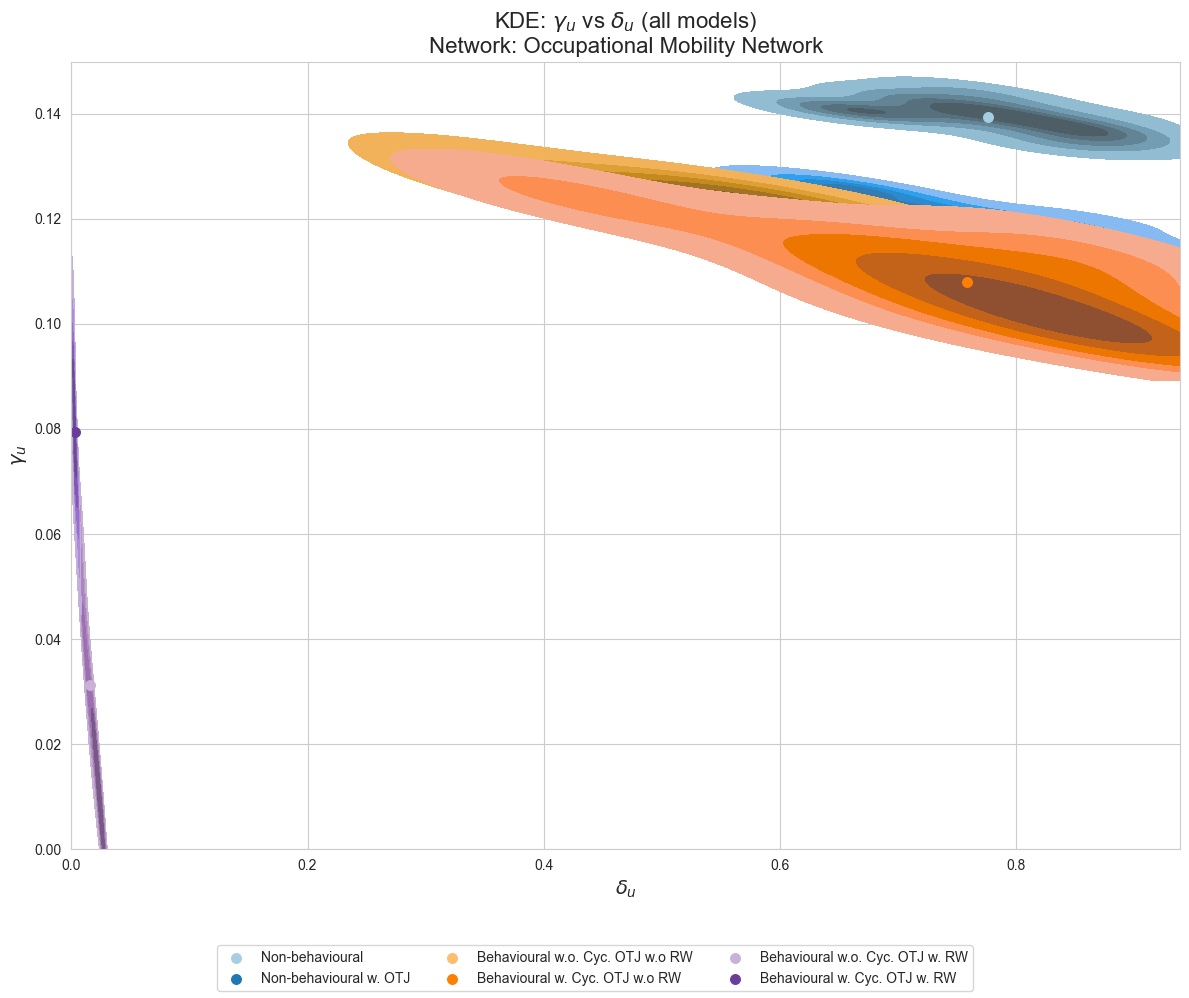

In [4]:
# ------------------- 1) Joint: d_u vs gamma_u (all models) -------------------
fig, ax = plt.subplots(figsize=(12,10))
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    print(name)
    if "d_u" not in df.columns or "gamma_u" not in df.columns:
        continue
    plot_kde_on_ax(ax, df["gamma_u"],  df["d_u"], weights=w, label=name_map.get(name, name), color=colors[name], levels=6, fill = True)
    #calib_gam = param_df.loc[(param_df['model_cat'] == name) & (param_df["Parameter"] == "gamma_u"),"Value"].iloc[0]
    #calib_du = param_df.loc[(param_df['model_cat'] == name) & (param_df["Parameter"] == "d_u"),"Value"].iloc[0]
    #ax.scatter( calib_gam,calib_du, marker = "x", color=colors[name], label=name_map.get(name, name))
                   # 'theta': param_df.loc[(param_df['model_cat'] == name) & (param_df["Parameter"] == "theta"),"Value"].iloc[0]}
    # weighted mean marker
    mx = np.average(df["gamma_u"].values, weights=w)
    my = np.average(df["d_u"].values, weights=w)
    ax.scatter(mx, my, s=50, marker="o", linewidth=0.8, color=colors[name], label=name_map.get(name, name))


ax.set_xlabel(r"$\delta_u$", fontsize = 14)
ax.set_ylabel(r"$\gamma_u$", fontsize = 14)
if du_lim: ax.set_ylim(max(0, du_min), du_max)
if gu_lim: ax.set_xlim(max(0, gu_min), gu_max)
ax.set_title(f"KDE: $\gamma_u$ vs $\delta_u$ (all models)\nNetwork: {nw_label}", fontsize = 16)
fig.legend(loc="lower center", ncol = 3)
plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
#plt.tight_layout()
plt.savefig(os.path.join(out_dir, "all_models_du_vs_gu.png"), dpi=300)
plt.show()
plt.close(fig)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

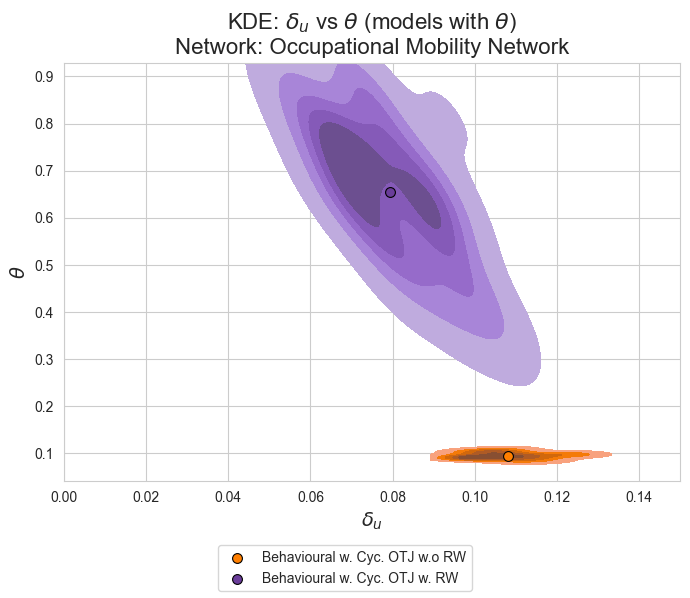

In [5]:
# ------------------- 2) Joint: d_u vs theta (only models with theta) -------------------
fig, ax = plt.subplots(figsize=(7,6))
any_theta = False
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "theta" not in df.columns:
        continue
    any_theta = True
    plot_kde_on_ax(ax, df["d_u"], df["theta"], weights=w,  color=colors[name], levels=6, fill =True)
    ax.scatter(np.average(df["d_u"].values, weights=w), np.average(df["theta"].values, weights=w),
               color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8, label=name_map.get(name, name))

if any_theta:
    ax.set_xlabel(r"$\delta_u$", fontsize = 14)
    ax.set_ylabel(r"$\theta$", fontsize = 14)
    if du_lim: ax.set_xlim(du_lim)
    if theta_lim: ax.set_ylim(theta_lim)
    ax.set_title(f"KDE: $\delta_u$ vs $\\theta$ (models with $\\theta$)\nNetwork: {nw_label}", fontsize = 16)
    #ax.legend(bbox_to_anchor=(0.5,-1), loc="lower center")
    fig.legend(loc="lower center", ncol = 1)
    plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
    plt.savefig(os.path.join(out_dir, "all_models_du_vs_theta.png"), dpi=300)
    plt.show()
    plt.close(fig)
else:
    print("No models had theta -> skipping d_u vs theta plot.")



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

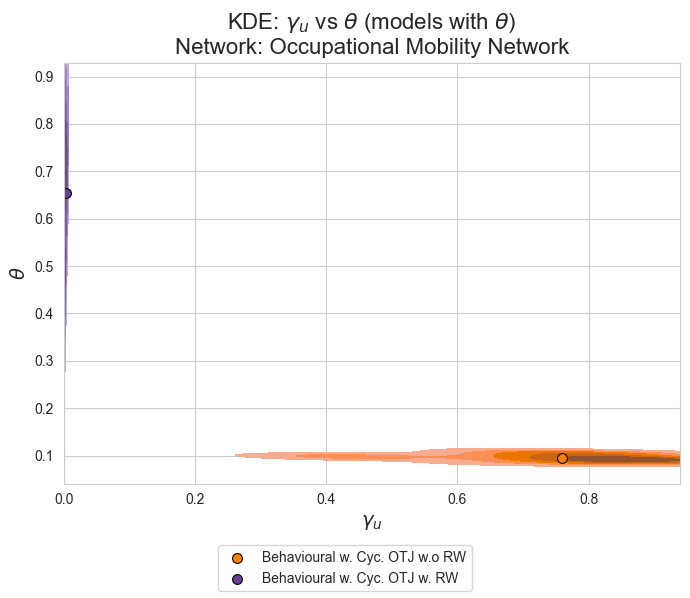

In [6]:

# ------------------- 3) Joint: gamma_u vs theta (only models with theta) -------------------
fig, ax = plt.subplots(figsize=(7,6))
any_theta = False
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "theta" not in df.columns:
        continue
    any_theta = True
    plot_kde_on_ax(ax, df["gamma_u"], df["theta"], weights=w, color=colors[name], levels=6, fill = True)
    ax.scatter(np.average(df["gamma_u"].values, weights=w), np.average(df["theta"].values, weights=w),label=name_map.get(name, name), 
               color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8)

if any_theta:
    ax.set_xlabel(r"$\gamma_u$", fontsize = 14)
    ax.set_ylabel(r"$\theta$", fontsize = 14)
    if gu_lim: ax.set_xlim(gu_lim)
    if theta_lim: ax.set_ylim(theta_lim)
    ax.set_title(f"KDE: $\gamma_u$ vs $\\theta$ (models with $\\theta$)\nNetwork: {nw_label}", fontsize = 16)
    fig.legend(loc="lower center", ncol = 1)
    plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
    plt.savefig(os.path.join(out_dir, "all_models_gu_vs_theta.png"), dpi=300)
    plt.show()
    plt.close(fig)
else:
    print("No models had theta -> skipping gamma_u vs theta plot.")



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

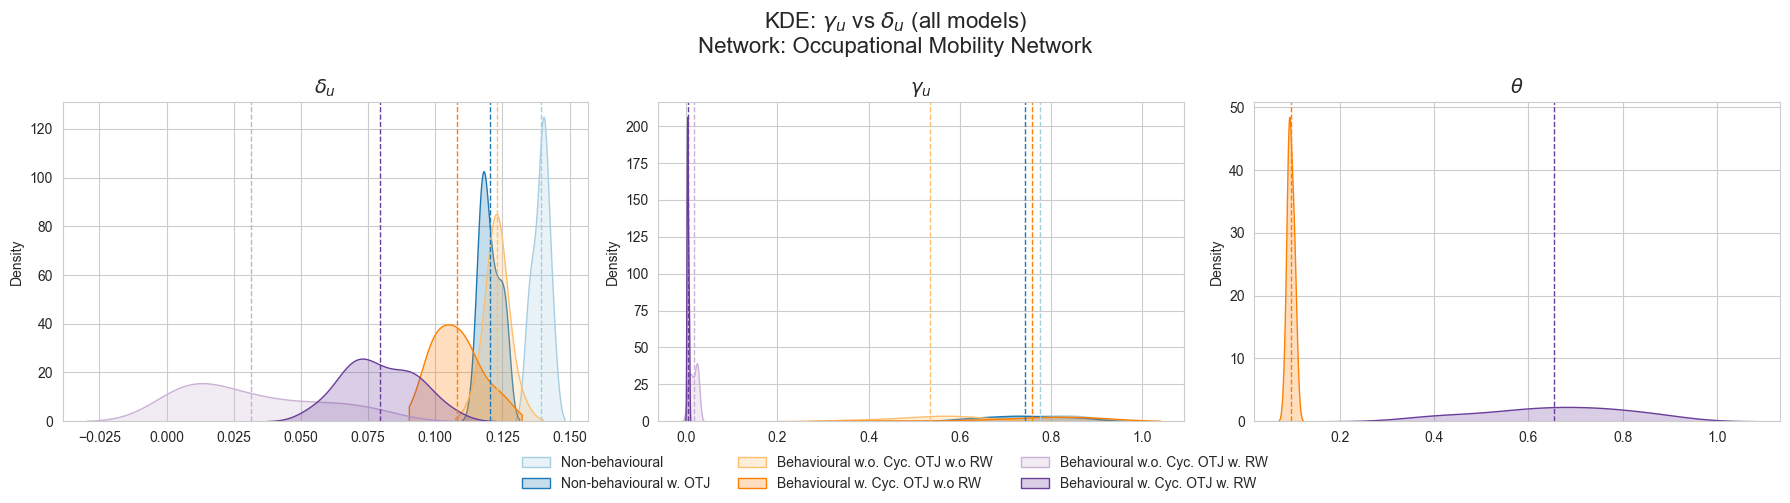

Saved combined plots to output/full_omn/combined_plots


In [7]:
# ------------------- 4) "Diagonal KDE matrix": 1D marginals overlaid -------------------
vars_to_plot = ["d_u", "gamma_u", "theta"]
fig, axes = plt.subplots(1, 3, figsize=(18,5))   # wider subplots

for idx, var in enumerate(vars_to_plot):
    ax = axes[idx]
    for name, meta in samples.items():
        df = meta["df"]
        w = meta["w"]
        if var not in df.columns:
            continue
        plot_kde_on_ax(ax, df[var], weights=w, label=name_map.get(name, name), color=colors[name], fill=True)
        # weighted mean vertical line
        ax.axvline(np.average(df[var].values, weights=w), color=colors[name], linestyle='dashed', linewidth=1)
    if var == "d_u":
        ax.set_title(r"$\delta_u$", fontsize = 14)
    elif var == "gamma_u":
        ax.set_title(r"$\gamma_u$", fontsize = 14)
    elif var == "theta":
        ax.set_title(r"$\theta$", fontsize = 14)
    ax.set_xlabel(None)

                     
# Place one combined legend below all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)
fig.suptitle(f"KDE: $\gamma_u$ vs $\delta_u$ (all models)\nNetwork: {nw_label}", fontsize = 16)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
plt.savefig(os.path.join(out_dir, "all_models_marginals.png"), dpi=300)
plt.show()
plt.close(fig)

print("Saved combined plots to", out_dir)